# GLMの尤度比検定と検定の非対称性

## 今回扱う検定と考え方
- この本においては、検定を推定された統計モデルを比較する手段として用いる
- 今回扱うのは、尤度比検定

### 尤度比検定とは
逸脱度に注目する検定手法

## 統計モデルの検定の考え方
比較したいネストされた2つの統計モデルがあったとき、尤度の低い方のモデルを帰無仮説、尤度の高い方のモデルを対立仮説とする。
- **逸脱度の差**を算出し、**帰無仮説を真としたとき**に、その差が有意水準5%で棄却できるかを調べる。
- 棄却できれば対立仮説を採用する

## 尤度比検定の例
- 使うデータ：今まで扱った種子データ
- 比較するモデル（上から帰無仮説、対立仮説）
$$
\begin{align}
\lambda_i &= e^{\beta_1}\\
\lambda_i &= e^{\beta_1+\beta_2x_i}
\end{align}
$$
- 二つのモデルの逸脱度について、その差を算出
- 帰無仮説が真として、このモデルからデータを何回も発生させ、逸脱度の差の分布を得る
- 上記で発生させた分布に最初に算出した逸脱度の差を当てはめたとき、有意水準5%で棄却できるかを調べる

### 順にデータの概要を追っていく

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
data = pd.read_csv('data3a.csv')
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [3]:
# 帰無仮説の一定モデルを作成
model_1 = smf.glm('y~1',data=data,family=sm.families.Poisson())
result_1 = model_1.fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Wed, 28 Jul 2021   Deviance:                       89.507
Time:                        05:48:10   Pearson chi2:                     87.1
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0580      0.036     57.586      0.000       1.988       2.128
==============================================================================
"""

In [4]:
# 対立仮説の一定モデルを作成
model_2 = smf.glm('y~x',data=data,family=sm.families.Poisson())
result_2 = model_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Wed, 28 Jul 2021   Deviance:                       84.993
Time:                        05:48:10   Pearson chi2:                     83.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

## 尤度比 

- 尤度比を対数変換して-2掛けることで、逸脱度の差を算出する

$$
\begin{align}
\frac{L_1^{*}}{L_2^{*}} &= \frac{e^{-237.64}}{e^{-235.39}}\\
\Delta D_{1,2} &= -2×(logL_1^{*}-logL_2^{*})
\end{align}
$$
- 逸脱度は同じデータに対して、パラメータ数の多いモデルのほうが常に小さくなる

In [6]:
# 尤度比を算出
np.exp(result_1.llf)/np.exp(result_2.llf)

0.10466708976326024

In [7]:
# 逸脱度の差
deviance_difference = result_1.deviance - result_2.deviance
deviance_difference

4.513941078851744

- 一定モデルに対して、xモデルは逸脱度が4.5改善されたといえる
- この4.5という数字は、一定モデルを真のモデルとしたときに有意といえる差なのかを調べ、本当に改善されているかを調べる

## 統計検定量$ \Delta D_{1,2} $のP値の算出

### パラメトリックブーストラップ法(parametric boostrap,PB)
- 一定モデルが真のモデルと仮定し、そこから乱数を作成
- 作成した乱数データに対して、一定モデル、xモデルを適用
- 上記について、逸脱度の差を算出
- 1000回ほど繰り返し、逸脱度の差の分布を導出
- 逸脱度の差の分布に対し、逸脱度の差4.5は有意であるか調べる

In [11]:
# 一定モデルを真として、乱数を作成
# 具体的には、一定モデルで推定された平均種子数を\lambdaとして、ポアソン乱数を作成する
log_ramda = result_1.params[0]
log_ramda

2.0579625100027115

- 上記で$log\lambda = 2.057…$を得た
- 次に$\lambda = e^{2.057…}$より\lambdaを得る

In [12]:
ramda = np.exp(log_ramda)
ramda

7.829999999999998

- $\lambda = 7.82999$として、ポアソン乱数を作成

In [13]:
np.random.seed(10)
data["y_rand"] = np.random.poisson(ramda, 100)
data.head()

,y,x,f,y_rand
0,6,8.31,C,6
1,6,9.44,C,5
2,6,9.50,C,11
3,12,9.07,C,10
4,10,10.16,C,6


In [14]:
# 平均が大体ramdaぐらいか確認
data.y_rand.mean()

7.45

In [15]:
# 上記の乱数に一定モデルとxモデルを適用、逸脱度の差を算出
model_1_rand = smf.glm('y_rand~1', data=data,family=sm.families.Poisson())
model_2_rand = smf.glm('y_rand~x', data=data,family=sm.families.Poisson())
result_1_rand = model_1_rand.fit()
result_2_rand = model_2_rand.fit()
result_1_rand.deviance - result_2_rand.deviance

2.7068337885090017

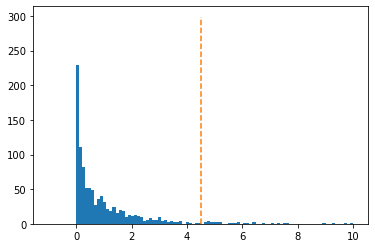

In [17]:
# 上記を1000回繰り返す
deviance_list = list()
for i in range(1000):
  data["y_rand"] = np.random.poisson(ramda,100)
  model_1_rand = smf.glm('y_rand~1',data=data,family=sm.families.Poisson())
  model_2_rand = smf.glm('y_rand~x',data=data,family=sm.families.Poisson())
  result_1_rand = model_1_rand.fit()
  result_2_rand = model_2_rand.fit()
  deviance_list.append(result_1_rand.deviance - result_2_rand.deviance)

# 逸脱度の差の分布を表示
plt.hist(deviance_list,bins=100,range=(-1,10))
# 最初に求めた逸脱度の差4.5の場所を点線で表示
plt.plot([4.5]*300,range(0,300),"--")


## P値を調べる

In [18]:
array = np.array(deviance_list)
# 4.5より大きい逸脱度が何個か表示
array[array>=4.5].shape

(37,)

- 1000個中37個がより極端な値をとる
- p値は37/1000で0.037

### p = 0.05となる逸脱度の差がどこか算出

In [19]:
np.percentile(deviance_list,95)

3.585291088501016

### 結論
- 逸脱度の差4.5は3.58より大きく、p値も3.7%程度で有意なので、帰無仮説：一定モデルのほうが優れているが棄却され、xモデルが採用される
- 尤度比検定が片側検定な理由は、パラメータが増えると必ず最大対数尤度は増加するから

## $ x^{2} $分布を使った近似計算法

- 逸脱度の差の確率分布は、近似的に自由度k（比較するモデル間のパラメータ数の差）の$ x^{2} $分布に従うことが知られている
- これを使って検定する
- ただし、$ x^{2} $分布に近似できるのは、サンプル数→∞としたときであるので、今回の様に、データが100個しかないようなときにはPB法を使ったほうが良い